# Checking sculpting of mass regression
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- make 1d histograms of the regressed mass for different samples at different tagger cuts

In [43]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [38]:
%load_ext autoreload
%autoreload 2

In [39]:
! ls ../eos/Apr12_presel_2017

DYJetsToLL_M-10to50                     SingleElectron_Run2017E
DYJetsToLL_Pt-100To250                  SingleElectron_Run2017F
DYJetsToLL_Pt-250To400                  SingleMuon_Run2017B
DYJetsToLL_Pt-400To650                  SingleMuon_Run2017C
DYJetsToLL_Pt-50To100                   SingleMuon_Run2017D
DYJetsToLL_Pt-650ToInf                  SingleMuon_Run2017E
GluGluHToTauTau                         SingleMuon_Run2017F
GluGluHToWW_Pt-200ToInf_M-125           TTTo2L2Nu
GluGluZH_HToWW_ZTo2L_M-125              TTToHadronic
HWminusJ_HToWW_M-125                    TTToSemiLeptonic
HWplusJ_HToWW_M-125                     VBFHToWWToLNuQQ_M-125_withDipoleRecoil
HZJ_HToWW_M-125                         WJetsToLNu_HT-100To200
QCD_Pt_1000to1400                       WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800                       WJetsToLNu_HT-200To400
QCD_Pt_170to300                         WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400                       WJetsToLNu_HT-400To600
QCD_Pt_2400to32

In [40]:
presel = {
    "mu": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",
        
        ### signal region
        "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",      

        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",        
    },
    "ele": {
        
        ### part of the preselection
        "lep_fj_dr": "( ( lep_fj_dr>0.03) )",

        ### signal region
        "tagger": " ( ( inclusive_score>0.9) )",
        
        ### top control region
#         "nbjets": "( (n_bjets_M >= 2) )",
        
        ### wjets control region        
#         "nbjets": "( (n_bjets_L == 0) )",     
        
        ### qcd control region
#         "tagger": " ( ( inclusive_score<0.9) )",
        
    }    
}

weights = {
    "ele": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_electron": 1,
        "weight_pileup": 1,
        "weight_reco_electron": 1,
        "weight_trigger_electron": 1,
        "weight_vjets_nominal": 1,
    },
    "mu": {
        "weight_L1Prefiring": 1,
        "weight_genweight": 1,
        "weight_id_muon": 1,
        "weight_isolation_muon": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_vjets_nominal": 1   ,
    },       
}

In [41]:
years = ["2017", "2016", "2016APV", "2018"]
channels = ["mu", "ele"]

samples_dir = f"../eos/Apr12_presel_"

samples = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
    "QCD",
#     "DYJets",
    "WJetsLNu",
#     "WZQQ",
    "TTbar",
#     "SingleTop",
#     "Diboson",
#     "Data"
]

In [6]:
from make_hists import make_events_dict
events_dict = make_events_dict(years, channels, samples_dir, samples, presel, weights, "all", add_tagger_score=True)

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
1.0949416558557916
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 37101 events
applying tagger selection on 4443 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 131 events
tot event weight 212.46127711555283 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.04037521924527721
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weig

---> Done with preselection.
Will fill the TTbar dataframe with the remaining 201 events
tot event weight 24.096805175079396 

Finding QCD_Pt_1000to1400 samples and should combine them under QCD
---> Accumulating event weights.
0.015609081084482931
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 2521 events
applying tagger selection on 1477 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 78 events
tot event weight 1.13473992139099 

Finding QCD_Pt_600to800 samples and should combine them under QCD
---> Accumulating event weights.
0.3245439095
Applying weight_L1Prefiring weight
Applying weight_genweig

---> Accumulating event weights.
0.0003367024440993835
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 1145640 events
applying tagger selection on 869405 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 30554 events
tot event weight 2768.2014583311784 

Finding WJetsToLNu_HT-1200To2500 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.009666731596105928
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done w

---> Applying preselection.
applying lep_fj_dr selection on 243360 events
applying tagger selection on 128984 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 23670 events
tot event weight 2578.0878642547586 

Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.0009182309549050811
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 84742 events
applying tagger selection on 57473 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4033 events
tot event weight 4.47473660933189 

Finding QCD_Pt_800to1000 samples and should combine them under QCD
---> Accumulatin

Finding TTTo2L2Nu samples and should combine them under TTbar
---> Accumulating event weights.
0.000407111312769749
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 316509 events
applying tagger selection on 256502 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 6224 events
tot event weight 172.03383635065126 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
3.134147809540762e-05
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
App

---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 23 events
tot event weight 34.428303547094636 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.03892997488073508
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 109526 events
applying tagger selection on 63805 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 10012 events
tot event weight 511.12641869797164 

Finding TTToSemiLeptonic samples and should combine them under TTbar
---> Accumulating event weights.
0.0014834484828709657
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying 

---> Accumulating event weights.
2.0834458052655185
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 11405 events
applying tagger selection on 4746 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 265 events
tot event weight 538.2680494553088 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
59.0533860566153
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulati

---> Accumulating event weights.
0.015385380036836687
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 10314 events
applying tagger selection on 9626 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 4838 events
tot event weight 33.094997431069345 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
2.6297124480000003e-06
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso

---> Applying preselection.
applying lep_fj_dr selection on 71327 events
applying tagger selection on 53586 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 4401 events
tot event weight 3.398694723992388 

Finding QCD_Pt_800to1000 samples and should combine them under QCD
---> Accumulating event weights.
0.01455630149100257
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 4925 events
applying tagger selection on 2731 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 108 events
tot event weight 1.5002387093252645 

Finding WJetsToLNu_HT-400To600 samples and should c

---> Accumulating event weights.
0.0005491480458960981
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 321220 events
applying tagger selection on 240646 events
---> Done with preselection.
Will fill the TTbar dataframe with the remaining 5507 events
tot event weight 186.89598898671443 

Finding QCD_Pt_2400to3200 samples and should combine them under QCD
---> Accumulating event weights.
3.403913792597533e-05
Applying weight_L1Prefiring weight
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Don

---> Accumulating event weights.
1.4672354798711078
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
Applying weight_vjets_nominal weight
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 33146 events
applying tagger selection on 3749 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 127 events
tot event weight 282.5178949366888 

Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.040404566496860805
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
App

applying tagger selection on 890 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 38 events
tot event weight 745.9969081924262 

Finding QCD_Pt_170to300 samples and should combine them under QCD
---> Accumulating event weights.
309.371643
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_muon weight
Applying weight_isolation_muon weight
Applying weight_pileup weight
Applying weight_trigger_iso_muon weight
Applying weight_trigger_noniso_muon weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 515 events
applying tagger selection on 286 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 12 events
tot event weight 3683.4679379727304 

Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.08511772808214786

applying tagger selection on 141621 events
---> Done with preselection.
Will fill the WJetsLNu dataframe with the remaining 14974 events
tot event weight 7235.740029158568 

Finding GluGluHToWW_Pt-200ToInf_M-125 samples and should combine them under HWW
---> Accumulating event weights.
0.025568054495254233
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 13954 events
applying tagger selection on 12803 events
---> Done with preselection.
Will fill the HWW dataframe with the remaining 6165 events
tot event weight 69.63138405155452 

Finding QCD_Pt_3200toInf samples and should combine them under QCD
---> Accumulating event weights.
1.3810812148464167e-05
weight_

0.07844261031309392
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
weight_vjets_nominal weight is not stored in parquet
---> Done with accumulating event weights.
---> Applying preselection.
applying lep_fj_dr selection on 5163 events
applying tagger selection on 2533 events
---> Done with preselection.
Will fill the QCD dataframe with the remaining 136 events
tot event weight 10.374903235551065 

Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
---> Accumulating event weights.
0.3625601048894215
weight_L1Prefiring weight is not stored in parquet
Applying weight_genweight weight
Applying weight_id_electron weight
Applying weight_pileup weight
Applying weight_reco_electron weight
Applying weight_trigger_electron weight
Applying weight_vjets_nominal weight
---> Done with accumulating

In [7]:
events_dict.keys()

dict_keys(['2017', '2016', '2016APV', '2018'])

In [8]:
events_dict["2017"]["mu"].keys()

dict_keys(['WJetsLNu', 'TTbar', 'HWW', 'QCD'])

# Check mass regression sculpting

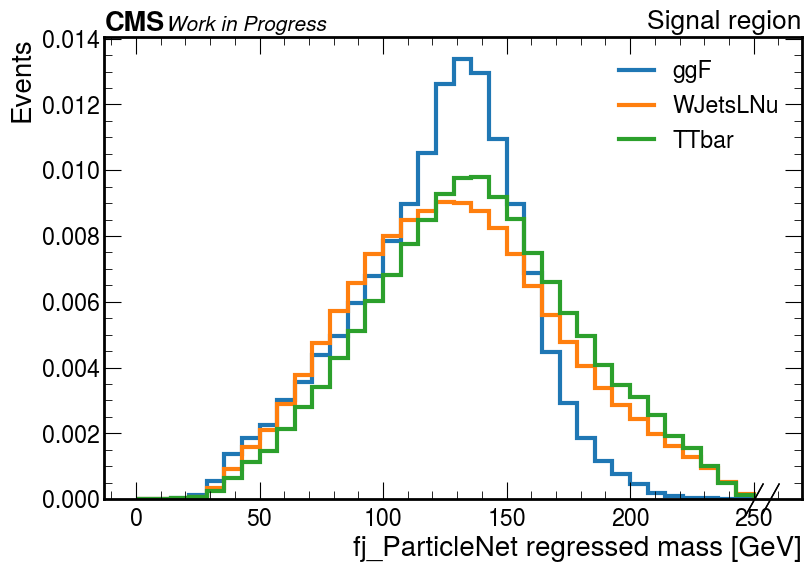

In [59]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
plt.rcParams.update({"font.size": 20})

var = "fj_ParticleNet_mass"
# var = "rec_higgs_m"
# var = "fj_minus_lep_m"

h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
#     hist2.axis.Regular(35, 0, 280, name="var", label=r"Jet - Lepton mass [GeV]", overflow=True),
)  

fig, ax = plt.subplots(figsize=(9, 6))

for sample in samples_to_plot:

    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]
            
            df = df[df["inclusive_score"]>0.9]            
#             df = df[df["n_bjets_M"]<2]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample

    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel("Events");  

ax.legend()
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "Signal region", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/hww/sensitivity/signal_region_{var}.pdf")

In [20]:
df["n_bjets_M"]

29      2
65      1
72      2
93      2
127     2
       ..
2778    0
2781    1
2789    1
2804    1
2821    0
Name: n_bjets_M, Length: 47530, dtype: int64

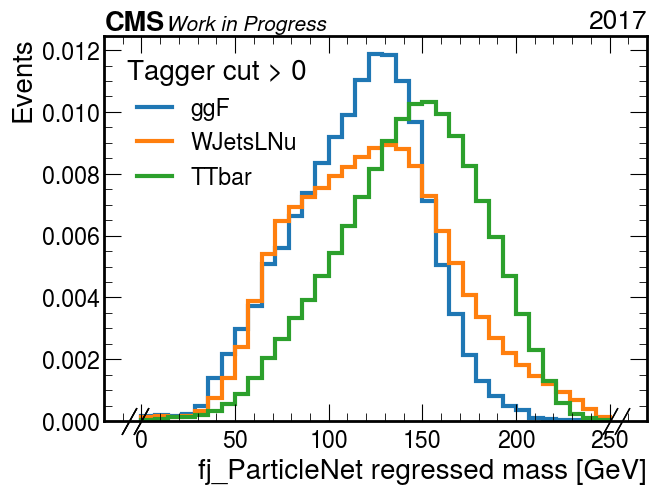

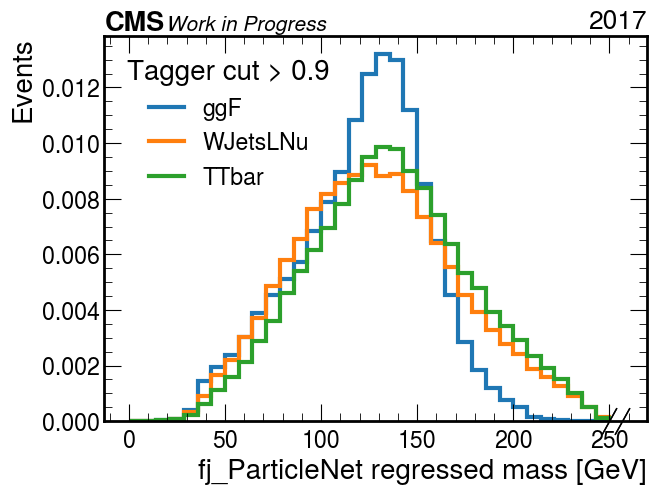

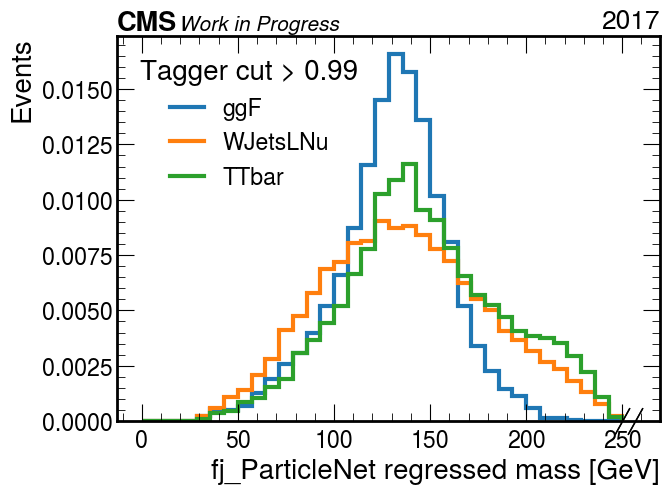

In [14]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
plt.rcParams.update({"font.size": 20})

var = "fj_ParticleNet_mass"

for tagger_cut in [0, 0.9, 0.99]:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )  

    fig, ax = plt.subplots(figsize=(7, 5))

    for sample in samples_to_plot:

        for year in years:
            for ch in channels:

                df = events_dict[year][ch][sample]

                # tagger cut
                df = df[df["inclusive_score"]>tagger_cut]

                h.fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"]
                )

    for sample in samples_to_plot:
        if sample in utils.sig_labels:
            lab = utils.sig_labels[sample]
        else:
            lab = sample

        hep.histplot(
            h[{"samples":sample}],
            ax=ax,
            label=lab,
            linewidth=3,
            density=True
        )

    ax.legend(title=f"Semi-Leptonic Channel")
    ax.set_ylabel("Events");  

    ax.legend(title=f"Tagger cut > {tagger_cut}")
    ax.set_ylabel("Events");  
    hep.cms.lumitext(
        "2017", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)

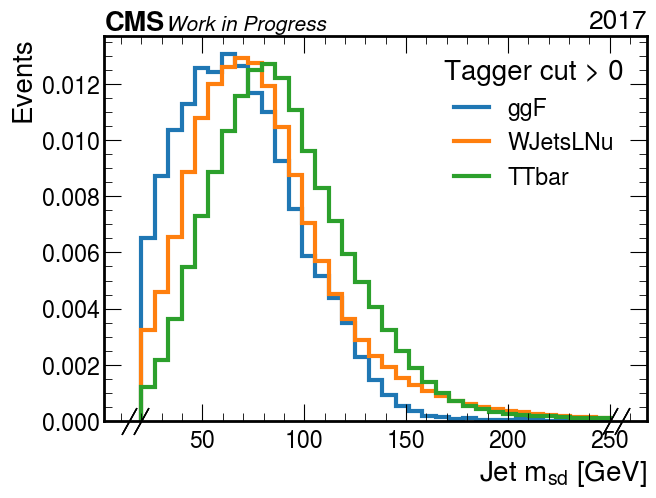

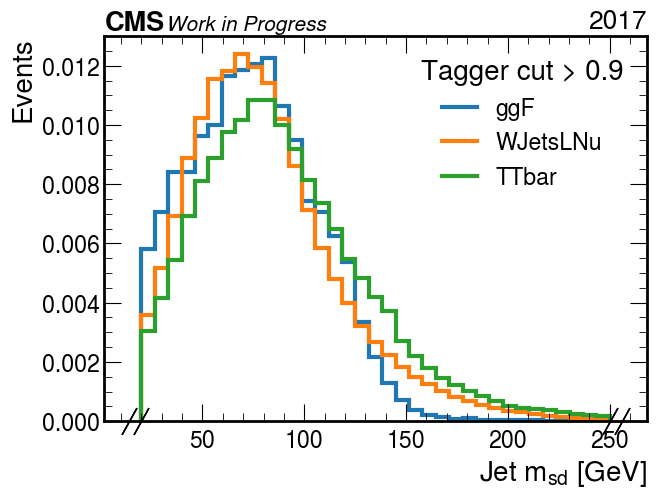

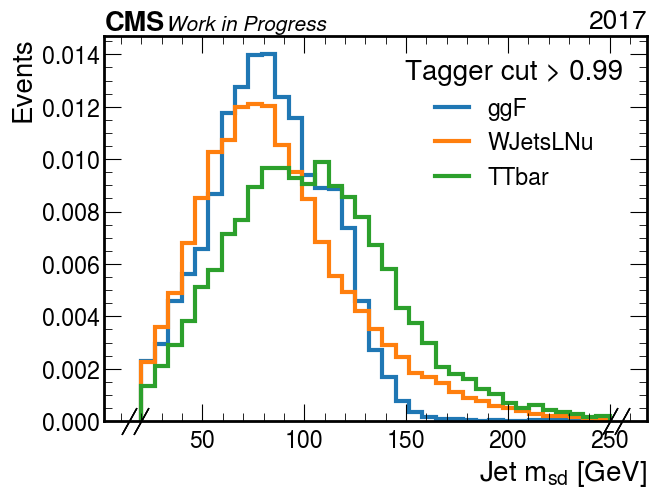

In [15]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
plt.rcParams.update({"font.size": 20})

var = "fj_msoftdrop"

for tagger_cut in [0, 0.9, 0.99]:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )  

    fig, ax = plt.subplots(figsize=(7, 5))

    for sample in samples_to_plot:

        for year in years:
            for ch in channels:

                df = events_dict[year][ch][sample]

                # tagger cut
                df = df[df["inclusive_score"]>tagger_cut]

                h.fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"]
                )

    for sample in samples_to_plot:
        if sample in utils.sig_labels:
            lab = utils.sig_labels[sample]
        else:
            lab = sample

        hep.histplot(
            h[{"samples":sample}],
            ax=ax,
            label=lab,
            linewidth=3,
            density=True
        )

    ax.legend(title=f"Semi-Leptonic Channel")
    ax.set_ylabel("Events");  

    ax.legend(title=f"Tagger cut > {tagger_cut}")
    ax.set_ylabel("Events");  
    hep.cms.lumitext(
        "2017", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)